# IBM SETI Tutorial 2 - Produce Spectrogram

This tutorial will show you how to build a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which is a measurement of the power of the signal across the observed bandwidth as a function of time. 

In [1]:
#!pip install --user --upgrade ibmseti
#!pip install --user --upgrade ibmos2spark

In [2]:
import ibmseti
import ibmos2spark as oss
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Get data from local Object Store

Use your object store credentials, available from the Data Source tab on the right (assuming that you've connected your Spark Service to an IBM Object Store).

In [1]:
credentials_1 = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xxx',
  'password':"xxx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xx',
  'project_id':'xx',
  'region':'dallas',
  'user_id':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'container':'seti_raw_data',
  'tenantId':'xx'
}

#Give the `credentials_` a "name" to use when configuring the Spark Hadoop Connector

credentials_1['name'] = 'my_seti_data' 

In [4]:
bmos = oss.bluemix2d(sc, credentials_1)

### Access and Unpack

The steps to access and unpack your data files will depend, of course, on where and how you saved them to disk.

Recall that the Rows in both cases, assuming you followed the [get_data tutorial](ibmseti_get_data_tutorial.ipynb), looks like

    {"aca_file": object_name,
      "target_name":"kepler1229b",
      "ra": ra, 
      "dec": dec, 
      "raw_data":r.content, 
      "http_status":r.status_code, 
      "signaldb_rows":row[1][2]
     }

#### Read the Data Set

In [5]:
rdd_pickled_hadoop = sc.pickleFile(bmos.url('seti_raw_data', 'kepler1229b.sigdb.archive-compamps.rdd.dict.pickle'))
%time first_row = rdd_pickled_hadoop.first()
raw_data = first_row['raw_data']

CPU times: user 7.75 ms, sys: 3.11 ms, total: 10.9 ms
Wall time: 16.3 s


In [6]:
len(raw_data)

1061928

## Example Spectrogram


In [9]:
aca = ibmseti.compamp.Compamp(raw_data) #archive-compamp (ACA)
spectrogram = ibmseti.dsp.compamp_to_spectrogram(aca)  #ibmseti library reads and analyzes data.
#calculates the frequency-bin and time-bin edges
freqbins = ibmseti.dsp.frequency_bins(aca.header())
timebins = ibmseti.dsp.time_bins(aca.header())

In [10]:
aca.header() #here's what the data header looks like

{'activity_id': 18681,
 'half_frame_bytes': 8232,
 'half_frame_number': 0,
 'number_of_half_frames': 129,
 'number_of_subbands': 16,
 'over_sampling': 0.25,
 'polarization': 1,
 'rf_center_frequency': 5571.415199999,
 'start_subband_id': 273,
 'subband_spacing_hz': 533.3333333333334}

In [11]:
for r in first_row['signaldb_rows']: print r  #just printing this to show you it's all there.

{u'inttimes': 94, u'pperiods': 25.200000763, u'pol': u'mixed', u'tgtid': 150096, u'sigreason': u'PsPwrT', u'freqmhz': 5571.419491666, u'dec2000deg': 46.997, u'container': u'setiCompAmp', u'objectname': u'2014-06-13/act18681/2014-06-13_11-26-48_UTC.act18681.dx2018.id-2.L.archive-compamp', u'ra2000hr': 19.832, u'npul': 3, u'acttype': None, u'power': 54.983, u'widhz': 2.778, u'catalog': u'keplerHZ', u'snr': 35.405, u'uniqueid': u'kepler8ghz_18681_2018_2_3698510', u'beamno': 2, u'sigclass': u'Cand', u'sigtyp': u'Pul', u'tscpeldeg': 78.409, u'drifthzs': -3.014, u'candreason': u'Confrm', u'time': u'2014-06-13T11:26:39Z', u'tscpazdeg': 306.957}
{u'inttimes': 94, u'pperiods': 25.200000763, u'pol': u'mixed', u'tgtid': 150096, u'sigreason': u'Confrm', u'freqmhz': 5571.419491666, u'dec2000deg': 46.997, u'container': u'setiCompAmp', u'objectname': u'2014-06-13/act18681/2014-06-13_11-26-48_UTC.act18681.dx2018.id-2.L.archive-compamp', u'ra2000hr': 19.832, u'npul': 3, u'acttype': u'target', u'power':

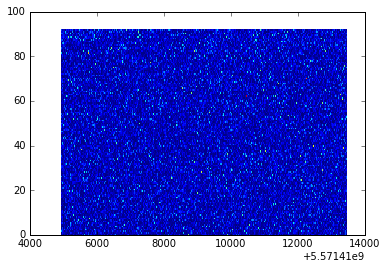

In [12]:
fig, ax = plt.subplots()
ax.pcolormesh(freqbins, timebins, spectrogram)  #Notice this is a "waterfall" plot going up. Typically t=0 is at the top of a "waterfall" plot

In [13]:
spectrogram.max()

264.0378930320914

In [14]:
spectrogram.mean()

17.745632196378935

##### Individual Pickled Files on Object Store
If you stored each of the raw data files as individual pickled objects, then you can access and unpack them like so.

In [10]:
rdd_pickle_with_sigdb = sc.binaryFiles(bmos.url('seti_raw_data', 'single_files/*'))
%time first_row = rdd_pickle_with_sigdb.first()
import cPickle
raw_data = cPickle.loads(first_row[1])['raw_data']

CPU times: user 8.64 ms, sys: 3.77 ms, total: 12.4 ms
Wall time: 1min 33s


### Spectrogram to Features

From the spectogram, one can [calculate a number of features](https://github.com/ibm-cds-labs/ibmseti#feature-extraction). Go to [the next tutorial to show how to perform feature extraction with Spark RDD maps](ibmseti_intro_features.ipynb).

## Examples of a clear signal

Much of the data, when viewed by eye, will look like the plot above. However, there must have been at least a very faint narrow-band signal in the data, or something similar, that triggered the ATA to acquired the data and write the full spectrum into an archive-compamp file. 

However, we do have data taken at the ATA while observing satellites passing over head. This data shows a much clearer signal to give you an idea of what a narrow-band signal looks like when it's loud and clear.

### Satellite Data

In 2014, the ATA observed the [ISEE3](https://en.wikipedia.org/wiki/International_Cometary_Explorer) spacecraft during the historic "reboot" of the satellite by private citizen scientists. From this data, one can clearly see the carrier signal. 

This is just one particular spectrogram where you can clearly see the signal.    

In [15]:
#This is data when observing the isee3 satellite
import requests

cont = 'setiCompAmp'
objname = '2014-08-11/act17713/2014-08-11_05-50-10_UTC.act17713.dx2009.id-2.R.archive-compamp'
get_temp_url = 'https://setigopublic.mybluemix.net/v1/data/url/{}/{}'.format(cont, objname)

r = requests.get(get_temp_url)
r = requests.get(r.json()['temp_url'])

rawdata = r.content

In [16]:
aca = ibmseti.compamp.Compamp(rawdata)
spectrogram = ibmseti.dsp.compamp_to_spectrogram(aca)  #ibmseti library reads and analyzes data.
freqbins = ibmseti.dsp.frequency_bins(aca.header())
timebins = ibmseti.dsp.time_bins(aca.header())

In [17]:
aca.header()

{'activity_id': 17713,
 'half_frame_bytes': 8232,
 'half_frame_number': 0,
 'number_of_half_frames': 257,
 'number_of_subbands': 16,
 'over_sampling': 0.25,
 'polarization': 0,
 'rf_center_frequency': 2217.4784,
 'start_subband_id': 198,
 'subband_spacing_hz': 533.3333333333334}

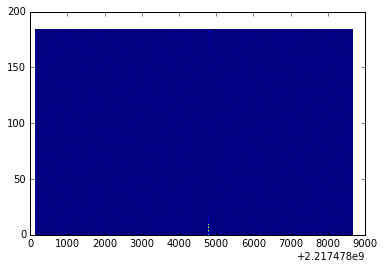

In [18]:
fig, ax = plt.subplots()
ax.pcolormesh(freqbins, timebins, spectrogram)

In [19]:
spectrogram.max()

8980.837642508377

In [20]:
spectrogram.mean()

17.858009074133026

#### Zoom In.

We can see the signal better if we zoom in a bit.

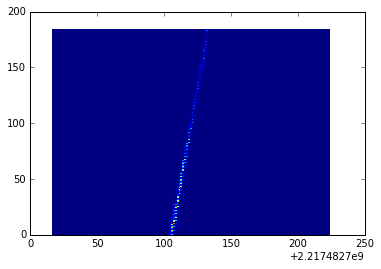

In [21]:
fig, ax = plt.subplots()
subpsec = spectrogram[:,3300:3450]
ax.pcolormesh(freqbins[3300:3450], timebins, subpsec)  

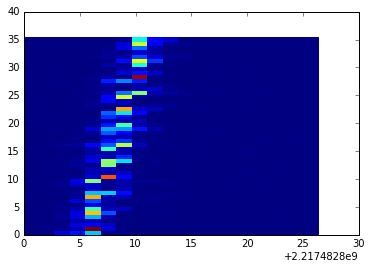

In [22]:
fig, ax = plt.subplots()
subpsec = spectrogram[0:50,3360:3380]
ax.pcolormesh(freqbins[3360:3380], timebins[0:50], subpsec) 

### More Spacecraft Data

You can get all of the spacecraft data from this endpoint [/v1/meta/aca/spacecraft](http://setigopublic.mybluemix.net/v1/aca/meta/spacecraft). (REST API documentation: setigopublic.md)

### Recently Interesting

At the NASA Ames Research center, the SETI group spent time on their HyperWall supercomputer, which has identified some interesting data. We have that raw data availble. Here is one particular observation. Currently, as far as I know, there's no explanation for this data. 

In [41]:
cont = 'setiCompAmp'
objname = '2014-09-20/act34347/2014-09-20_23-58-17_UTC.act34347.dx1012.id-14.L.archive-compamp'

get_temp_url = 'https://setigopublic.mybluemix.net/v1/data/url/{}/{}'.format(cont, objname)

r = requests.get( requests.get(get_temp_url).json()['temp_url'] )

rawdata = r.content


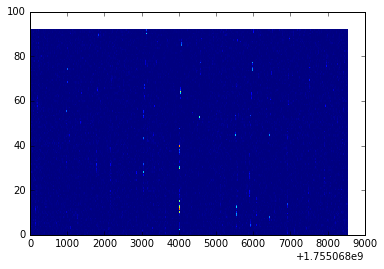

In [42]:
aca = ibmseti.compamp.Compamp(rawdata)
spectrogram = ibmseti.dsp.compamp_to_spectrogram(aca)  #ibmseti library reads and analyzes data.
freqbins = ibmseti.dsp.frequency_bins(aca.header())
timebins = ibmseti.dsp.time_bins(aca.header())

fig, ax = plt.subplots()
ax.pcolormesh(freqbins, timebins, spectrogram)

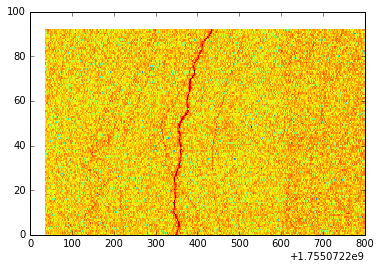

In [43]:
## Lots of high-power signals across the observed spectrum... let's zoom in. 
# We typically view Power on log scale

fig, ax = plt.subplots()
ax.pcolormesh(freqbins[3050:3600], timebins, np.log(spectrogram[:,3050:3600]))


In [44]:
spectrogram.max()

3699.2602223299709

In [45]:
spectrogram.mean()

17.972505793380918

##### More Data
The RA,DEC coordinates for this data is 19.551,44.869. 
There are 1830 rows of data for this coordinate
http://setigopublic.mybluemix.net/v1/aca/meta/19.551/44.869